# Dataset

## Calibration of AMPA-to-NMDA ratio

In [1]:
%matplotlib inline
from datavyz import ge

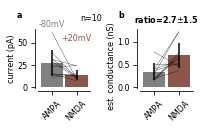

In [2]:
import numpy as np
from data.exp_datasets import SYN_CONDUCTANCE_MEASUREMENTS
fig, AX = ge.figure(axes=(2,1), figsize=(.9,1.3), wspace=1.5, top=1.2)
for v1, v2 in zip(SYN_CONDUCTANCE_MEASUREMENTS['ampa'], SYN_CONDUCTANCE_MEASUREMENTS['nmda']):
    AX[0].plot([0,1], [v1, v2], 'k-', lw=0.3)
    AX[1].plot([0,1], [v1/80, v2/20], 'k-', lw=0.3)
ge.bar(np.array([np.mean(SYN_CONDUCTANCE_MEASUREMENTS['ampa']),
                 np.mean(SYN_CONDUCTANCE_MEASUREMENTS['nmda'])]),
       sy=np.array([np.std(SYN_CONDUCTANCE_MEASUREMENTS['ampa']),
                    np.std(SYN_CONDUCTANCE_MEASUREMENTS['nmda'])]),
       COLORS=[ge.grey, ge.brown],
       ax=AX[0],
       axes_args=dict(ylabel='current (pA)', xticks=[0, 1], xticks_labels=['AMPA', 'NMDA'], xticks_rotation=45))
for i, v, val in zip(range(2), ['-80', '+20'], [65, 50]):
    ge.annotate(AX[0],'%smV'%v,(i,val),xycoords='data', ha='center', color=[ge.grey, ge.brown][i])

ge.bar(np.array([np.mean(SYN_CONDUCTANCE_MEASUREMENTS['ampa'])/80.,
                 np.mean(SYN_CONDUCTANCE_MEASUREMENTS['nmda'])/20.]),
       sy=np.array([np.std(SYN_CONDUCTANCE_MEASUREMENTS['ampa'])/80.,
                    np.std(SYN_CONDUCTANCE_MEASUREMENTS['nmda'])/20.]),
       COLORS=[ge.grey, ge.brown],
       ax=AX[1],
       axes_args=dict(ylabel='est. conductance (nS)      ', xticks=[0, 1], xticks_labels=['AMPA', 'NMDA'], xticks_rotation=45))

RATIOS = np.array(SYN_CONDUCTANCE_MEASUREMENTS['nmda'])/np.array(SYN_CONDUCTANCE_MEASUREMENTS['ampa'])*80/20
ge.annotate(AX[0], 'n=%i' % len(RATIOS), (.8,1.11))
ge.title(AX[1], 'ratio=%.1f$\pm$%.1f' % (np.mean(RATIOS), np.std(RATIOS)), bold=True)
for l, ax in zip(['a', 'b'], AX):
    ge.top_left_letter(ax, l, loc=(-.3,1.15))
ge.savefig(fig, 'figures/ampa-nmda-ratio.png')       

## Runs for parameter calibration

In [3]:
import numpy as np
import os
from analyz.workflow.batch_run import GridSimulation, bash_script

N = 30
GRID = {'gL':np.linspace(0.1, 10., N),
        'cm':np.linspace(0.5, 2., N)}

np.savez(os.path.join('data', 'calib', 'passive-grid.npz'), **GRID)
# Making a bash script to run a scan on the above grid grid
sim = GridSimulation(GRID)
bs = bash_script('calib-passive')
bs.script = sim.build_script('python passive_props.py calib',
                             base_script=bs.script, simultaneous_runs=8)
bs.write(folder='bash')

N = 8
GRID = {'tauDecayNMDA':np.linspace(65, 120, N),
        'Nsyn1':np.linspace(5, 50, N, dtype=int),
        'Nsyn2':np.linspace(5, 50, N, dtype=int),
        'Tnsyn':np.linspace(100, 2000, N)}

np.savez(os.path.join('data', 'calib', 'chelated-zinc-calib-grid.npz'), **GRID)
# Making a bash script to run a scan on the above grid grid
sim = GridSimulation(GRID)
bs = bash_script('calib-chelated-zinc')
bs.script = sim.build_script('python calibration-runs.py chelated-zinc-calib',
                             base_script=bs.script, simultaneous_runs=3*8)
bs.write(folder='./bash/')

Ngrid = 7
GRID = {'alphaZn': np.linspace(0.3, 0.7, Ngrid),
        'tauRiseZn':np.logspace(np.log10(1), np.log10(40), Ngrid),
        'tauDecayZn':np.logspace(np.log10(20), np.log10(500), Ngrid)}
# ,
#         'Deltax0':np.linspace(0.3, 0.7, Ngrid),
#         'deltax':np.linspace(0.05, 0.3, Ngrid)}

np.savez(os.path.join('data', 'calib', 'free-zinc-calib-grid.npz'), **GRID)

# Making a bash script to run a scan on the above grid grid
sim = GridSimulation(GRID) # os.path.join('data', 'calib', 'passive-grid.npz'))
bs = bash_script('calib-free-zinc')
bs.script = sim.build_script('python calibration-runs.py free-zinc-calib',
                             base_script=bs.script, simultaneous_runs=3*8)
bs.write(folder='./bash/')

# Dataset

In [4]:
root_folder = 'D:\\DATA\\Data_Nunzio'
List = os.listdir(os.path.dirname(os.path.join(root_folder, filename_to_path('nm19May2019c7_000.h5.pxp'))))
List

NameError: name 'filename_to_path' is not defined

In [5]:
filename_to_path(fn)

NameError: name 'filename_to_path' is not defined

In [6]:
from data.exp_datasets import VC_STEPS_DATASET as DATASET

PROPERTIES = {} # This will store the analysis results
def add_to(PROPERTIES, key, dtype=float):
    PROPERTIES[key] = {}
    for k in DATASET:
        PROPERTIES[key][k] = []
        for d in DATASET[k]:
            new_d = {}
            for kk in d:
                new_d[kk] = np.zeros(len(d[kk]), dtype=dtype)
            PROPERTIES[key][k].append(new_d)
# e.g use as: "add_to(PROPERTIES, 'Rm', dtype=float)"

In [7]:
import os, sys
import numpy as np
from analyz.IO.igor import load_hdf5_exported_from_Igor as load_data
from analyz.processing.filters import butter_lowpass_filter
%matplotlib inline
from datavyz import gedn as ge

In [8]:

def abbrev_to_month(abbrev):
    M = ['January', 'February', 'March', 'April', 'May',\
         'June', 'July', 'August', 'September', 'October',\
         'November', 'December']
    for m in M:
        if (m[:3].lower()==abbrev.lower()):
            return m

        
def filename_to_path(filename):
    day, month, year = filename[2:4], filename[4:7], filename[7:11]
    cell = filename[11:13]
    cond = filename[14:17]
    return os.path.join(year, abbrev_to_month(month), filename[:13], filename)


def plot_protocol(D, tzoom=[0, np.inf]):
    fig, AX = ge.figure(axes_extents=[[[3,1]] for i in range(3)]+[[[3,3]]], hspace=0.3, figsize=(1,.6))
    tcond = (D['t']>=tzoom[0]) & (D['t']<tzoom[1])
    ge.title(AX[0], D['filename'].split(os.path.sep)[-1])
    ge.plot(1e-3*D['t'][tcond], D['stimulations'][D['Vcmd_key']][tcond],
            ax=AX[0], axes_args={'spines':['left'], 'ylabel':'Vcmd (mV)'})
    ge.plot(1e-3*D['t'][tcond], D['stimulations'][D['stim_key']][tcond],
            ax=AX[1], axes_args={'spines':['left'], 'ylabel':'Stim (V)'})
    for i in range(D['recordings'][D['Irec_key']].shape[0]):
        AX[2].plot(1e-3*D['t'][tcond], D['recordings'][D['Irec_key']][i,tcond],
                   color='lightgray', lw=0.3) 
    ge.plot(1e-3*D['t'][tcond], D['recordings'][D['Irec_key']].mean(axis=0)[tcond],
            ax=AX[2], axes_args={'spines':['left'], 'ylabel':'raw I (nA)'})
    # now blanking the stimulus period
    for i in range(D['recordings'][D['Irec_key']].shape[0]):
        AX[3].plot(1e-3*D['t'][tcond], D['recordings']['Irecording_clean'][i,tcond],
                   color='lightgray', lw=0.3) 
    ge.plot(1e-3*D['t'][tcond], D['recordings']['Irecording_clean'].mean(axis=0)[tcond],
            ax=AX[3], axes_args={'xlabel':'time (s)', 'ylabel':'I (nA)'})

    
def LoadData(protocol,
             iexp=0, condition='Control', irec=0,
             dt_subampling=0,
             Fcutoff = 2000., # for low pass filtering
             verbose=False):
    if sys.platform=='win32': # Windows
        root_folder = 'D:\\DATA\\Data_Nunzio'
    else:
        root_folder = '/media/yann/DATADRIVE1/DATA/Data_Nunzio'

    fn = os.path.join(root_folder,
                      filename_to_path(DATASET[protocol][iexp][condition][irec]))
    try:
        data = load_data(fn, dt_subsampling=dt_subampling, verbose=verbose)
        data['filename'] = fn
        if 'stim' in data['stimulations']:
            data['stim_key'] = 'stim'
        else:
            data['stim_key'] = 'Stimulator'
        if 'Vcommand2' in data['stimulations']:
            data['Vcmd_key'] = 'Vcommand2'
        else:
            data['Vcmd_key'] = 'Vcommand'
        if 'Irecording2' in data['recordings']:
            data['Irec_key'] = 'Irecording2'
        else:
            data['Irec_key'] = 'Irecording'
    except (UnboundLocalError, KeyError):
        print('/!\ -- File corrupted ! -- /!\ ')
        print(fn)
        from analyz.IO.hdf5 import load_dict_from_hdf5
        data = load_dict_from_hdf5(fn)
    if Fcutoff>0:
        # adding low pass filtering
        Facq = 1./(data['t'][1]-data['t'][0])*1e3
        for i in range(data['recordings'][data['Irec_key']].shape[0]):
            data['recordings'][data['Irec_key']][i,:] =\
                butter_lowpass_filter(data['recordings'][data['Irec_key']][i,:], Fcutoff, Facq, order=5)
        
    data = remove_stimulation_artefact(data)
        
    return data

def remove_stimulation_artefact(D,
                                Tborder=2, # both in ms
                                Twindow=0.01):
    """
    For comparison with the theoretical model, the electrical artefact following extracellular stimulation in the voltage-clamp recordings was removed. This was performed by replacing the values during stimulation (TTL>0mV) by a linear interpolation of the signal using the pre- and post-stimulus recorded value.
    """
    iborder = int(Tborder/(D['t'][1]-D['t'][0])) # Tborder & t in ms
    iwindow = int(Twindow/(D['t'][1]-D['t'][0])) # Tborder & t in ms
    D['recordings']['Irecording_clean'] = 1.*D['recordings'][D['Irec_key']]
    rounded_stim = np.round(D['stimulations'][D['stim_key']],0)
    threshold = np.mean(np.unique(rounded_stim))/2.
    iup = np.argwhere((rounded_stim[1:]>threshold) & (rounded_stim[:-1]<=threshold)).flatten()
    idown = np.argwhere((rounded_stim[1:]<=threshold) & (rounded_stim[:-1]>=threshold)).flatten()

    for i0, i1 in zip(iup, idown):
        Y0 = D['recordings'][D['Irec_key']][:,i0-iborder-iwindow:i0-iborder].mean(axis=1)
        Y1 = D['recordings'][D['Irec_key']][:,i1+iborder:i1+iborder+iwindow].mean(axis=1)
        for i in range(i0-iborder, i1+iborder):
            # linear interpolation with respect to stimulus borders
            D['recordings']['Irecording_clean'][:,i] = Y0+(Y1-Y0)*(i-(i0-iborder))/(i1-i0+2*iborder)
    return D



In [9]:
## Importing electrophy/intracellular module
import sys
sys.path.append(os.path.join(os.path.expanduser('~'), 'work', 'cortical-physio-icm')) # append CPI to your path to be able to import
from electrophy.intracellular.passive_props import extract_VCcharact, from_VCcharact_to_membrane_parameters

CT_RecordMode
CT_TimeIntvl
CT_TimeStamp
FileDateTime
FileFormat
NMPrefix_Record
Notes
RecordA0
RecordA1
RecordA10
RecordA11
RecordA12
RecordA13
RecordA14
RecordA2
RecordA3
RecordA4
RecordA5
RecordA6
RecordA7
RecordA8
RecordA9
SampleInterval
SamplesPerWave
V_Flag
V_Progress
nmStimNunzio_train_5Hz
yLabel
CT_RecordMode
CT_TimeIntvl
CT_TimeStamp
FileDateTime
FileFormat
NMPrefix_Record
Notes
RecordA0
RecordA1
RecordA10
RecordA11
RecordA12
RecordA13
RecordA14
RecordA2
RecordA3
RecordA4
RecordA5
RecordA6
RecordA7
RecordA8
RecordA9
SampleInterval
SamplesPerWave
nmStimNunzio_train_5Hz
yLabel
CT_RecordMode
CT_TimeIntvl
CT_TimeStamp
FileDateTime
FileFormat
NMPrefix_Record
Notes
RecordA0
RecordA1
RecordA10
RecordA11
RecordA12
RecordA13
RecordA14
RecordA2
RecordA3
RecordA4
RecordA5
RecordA6
RecordA7
RecordA8
RecordA9
SampleInterval
SamplesPerWave
nmStimNunzio_train_5Hz
yLabel
CT_RecordMode
CT_TimeIntvl
CT_TimeStamp
FileDateTime
FileFormat
NMPrefix_Record
Notes
RecordA0
RecordA1
RecordA10
RecordA11


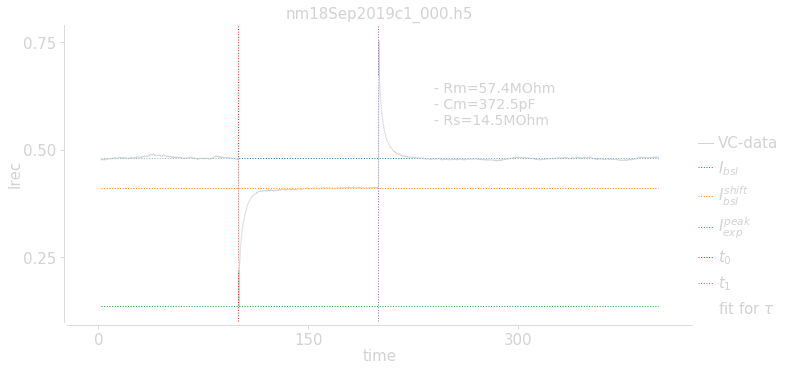

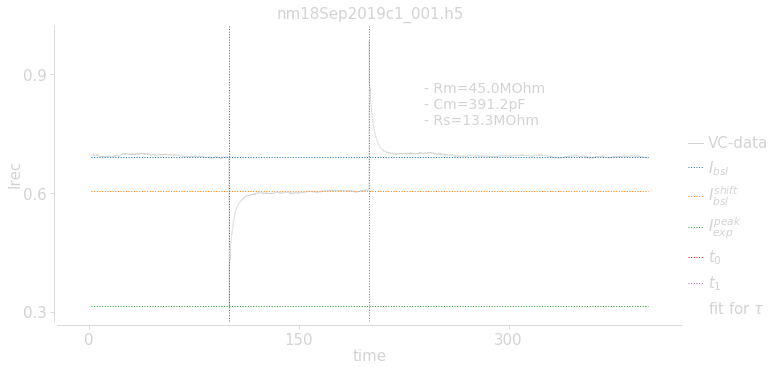

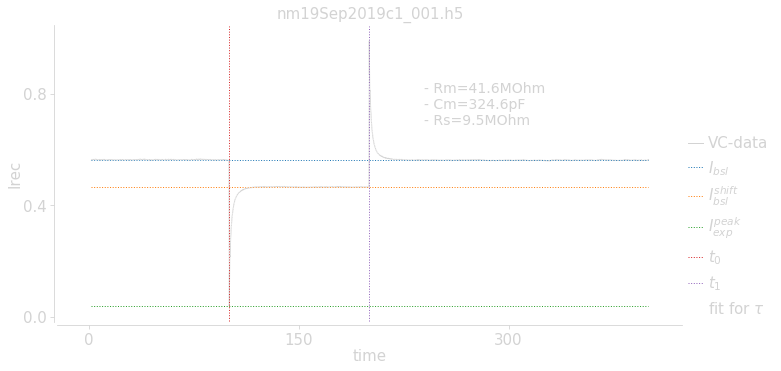

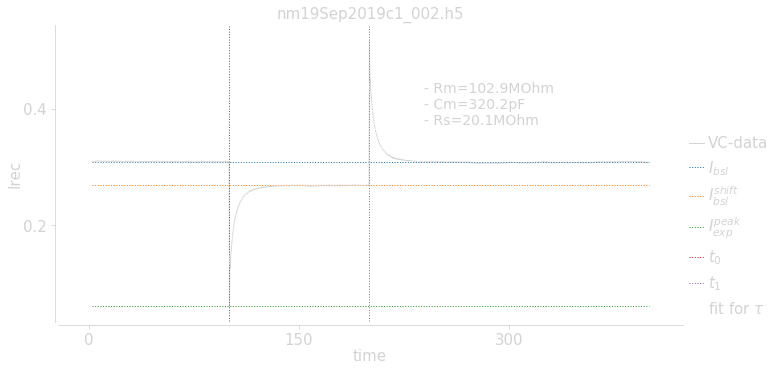

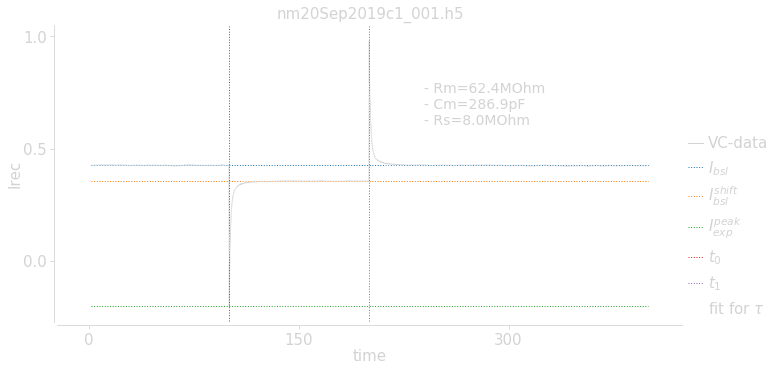

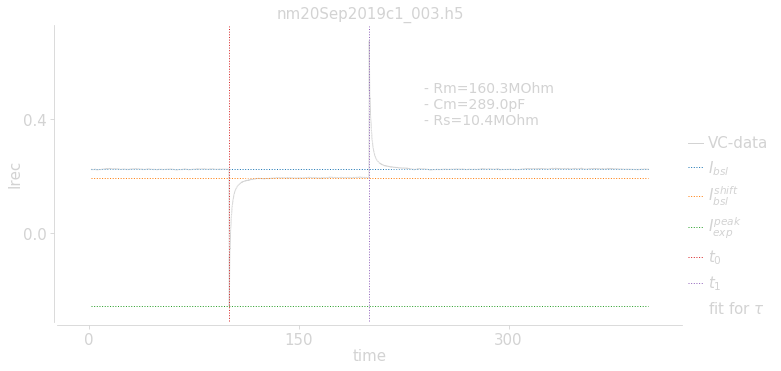

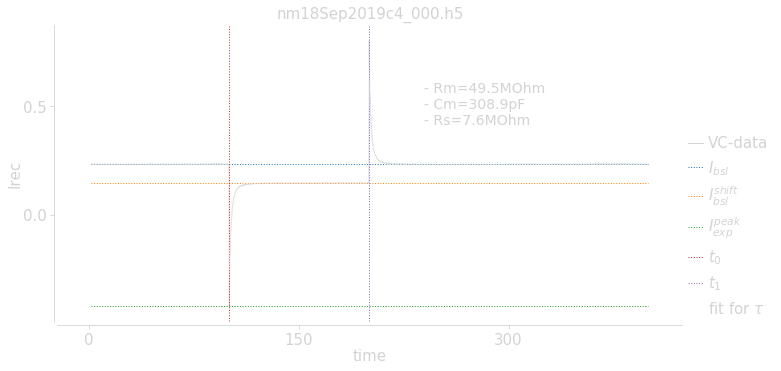

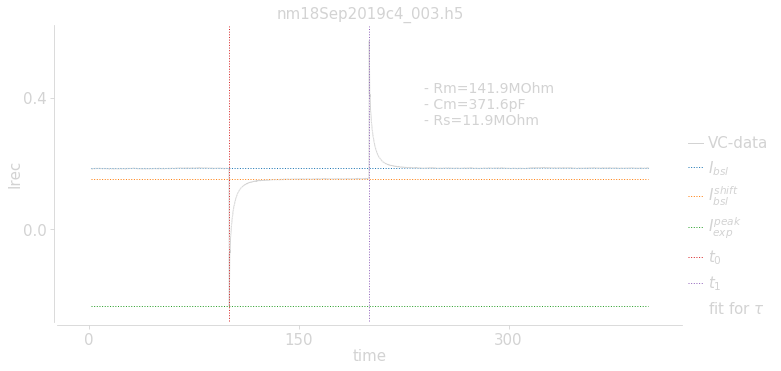

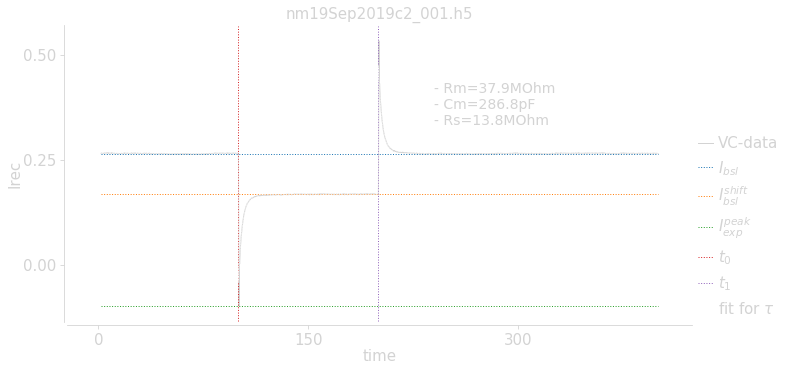

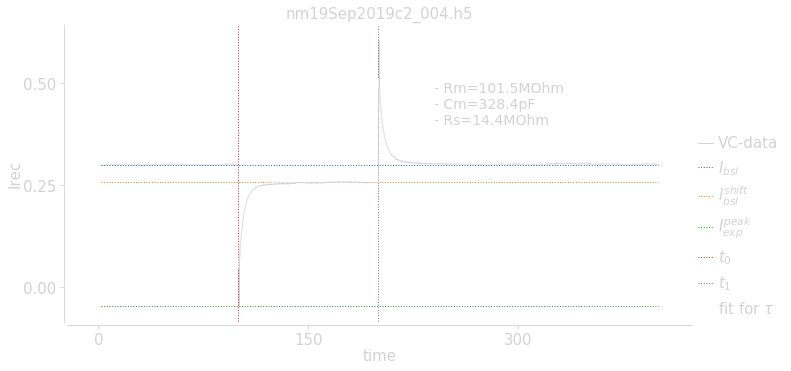

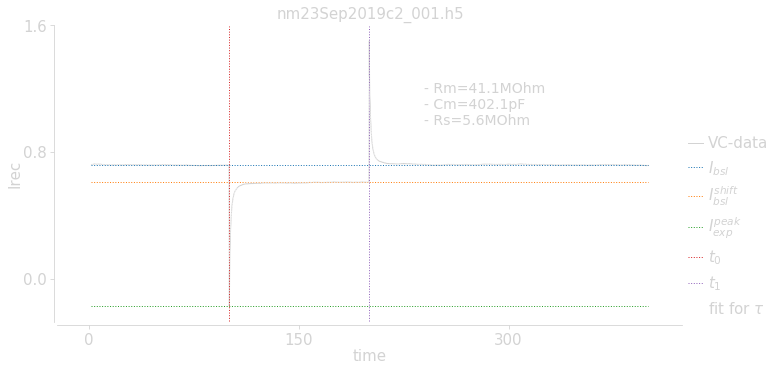

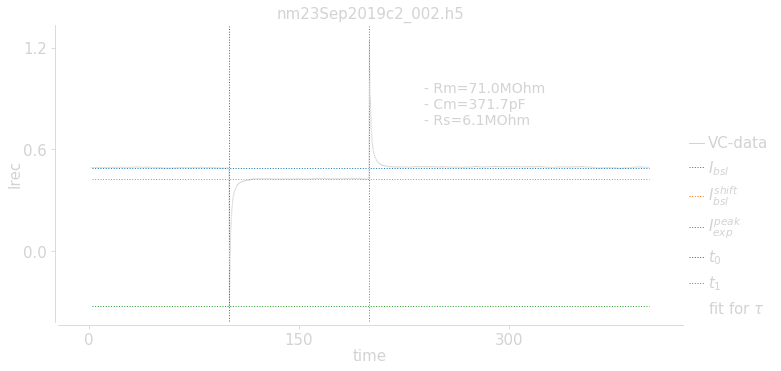

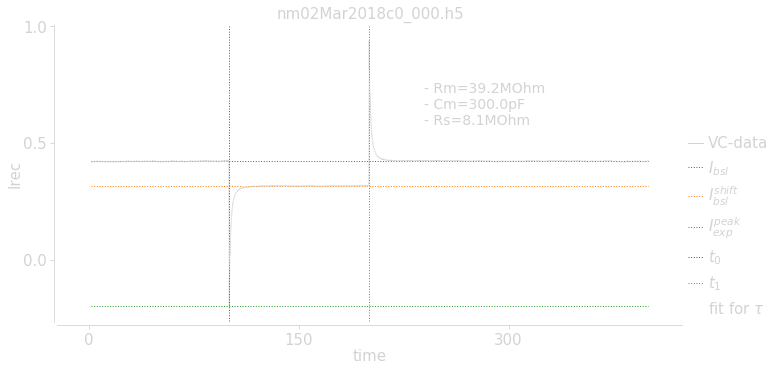

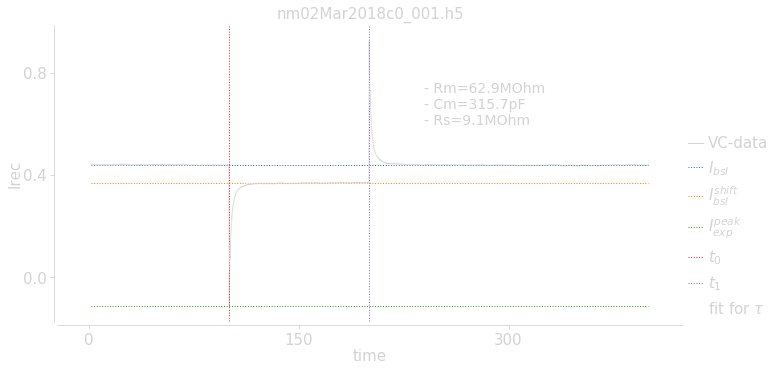

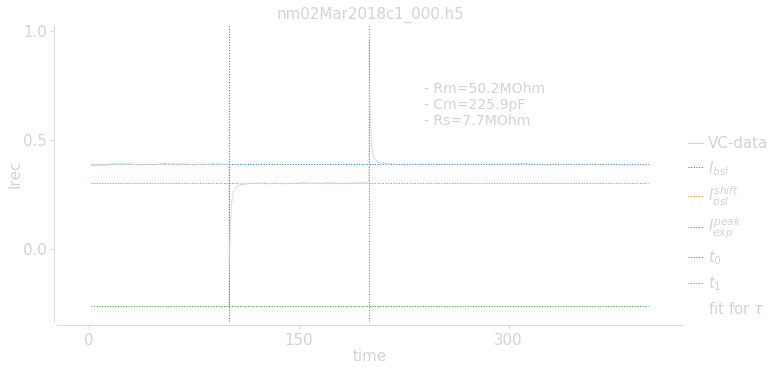

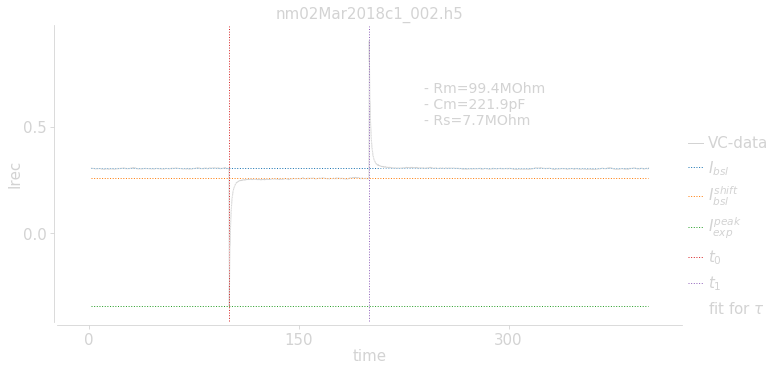

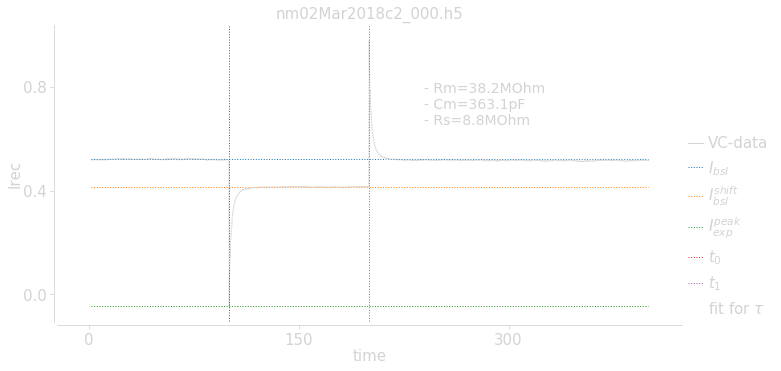

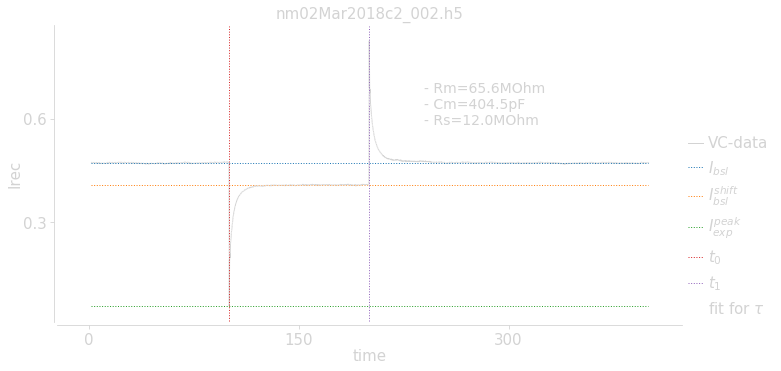

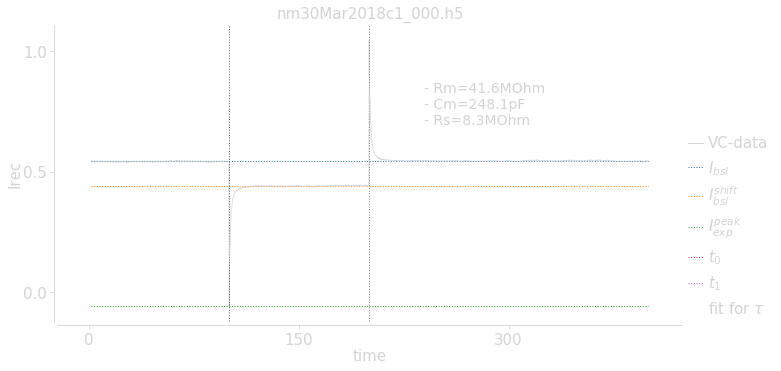

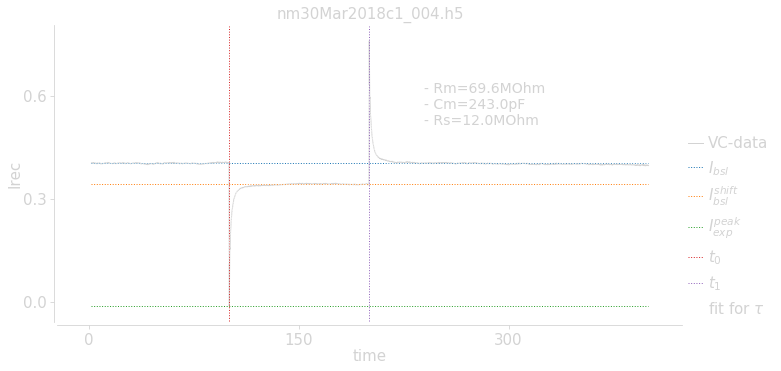

In [10]:
from scipy.optimize import minimize

add_to(PROPERTIES, 'Rm', dtype=float)
add_to(PROPERTIES, 'Cm', dtype=float)
add_to(PROPERTIES, 'Rs', dtype=float)

cond = '3Hz_protocol'

for prtcl in ['3Hz_protocol', '20Hz_protocol']:
    for i, cell in enumerate(DATASET[prtcl]):
        for cond in ['Control', 'Tricine']:
            data = LoadData(prtcl, iexp=i, condition=cond)

            t = data['t']
            tcond = (t>2) & (t<400)
            trace = data['recordings'][data['Irec_key']].mean(axis=0)
            fig, ax, IbslShift, IexpPeak, Tau = extract_VCcharact(t[tcond], trace[tcond],
                                                                  t0=100, t1=200,
                                                                  with_plot=True, ge=ge,
                                                    title=data['filename'].split(os.path.sep)[-1])
            Rm, Cm, Rs = from_VCcharact_to_membrane_parameters(1e-9*IbslShift, 1e-9*IexpPeak, 1e-3*Tau)
            ge.annotate(ax, """
            - Rm=%.1fMOhm
            - Cm=%.1fpF
            - Rs=%.1fMOhm
            """ % (1e-6*Rm, 1e12*Cm, 1e-6*Rs), (.5,.6), size='small')
            PROPERTIES['Rm'][prtcl][i][cond][0] = Rm
            PROPERTIES['Cm'][prtcl][i][cond][0] = Cm
            PROPERTIES['Rs'][prtcl][i][cond][0] = Rs
    


# Passive properties

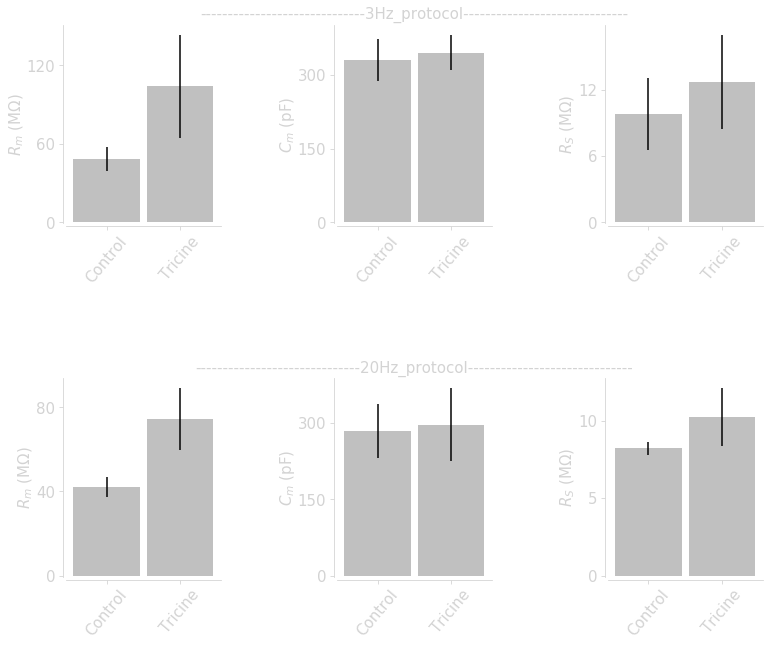

In [11]:
Rm, Cm, Rs = {}, {}, {}

fig, AX = ge.figure(axes=(3,2), figsize=(.7,1.), wspace=1.3, hspace=1.3)

Rm[cond], Cm[cond], Rs[cond] = [], [], []

for prtcl, axs in zip(['3Hz_protocol', '20Hz_protocol'], AX):
    
    for cond in ['Control', 'Tricine']:
        Rm[cond], Cm[cond], Rs[cond] = [], [], []
        
    for i, cell in enumerate(DATASET[prtcl]):
        for cond in ['Control', 'Tricine']:
            Rm[cond].append(PROPERTIES['Rm'][prtcl][i][cond][0])
            Cm[cond].append(PROPERTIES['Cm'][prtcl][i][cond][0])
            Rs[cond].append(PROPERTIES['Rs'][prtcl][i][cond][0])

    ge.bar([1e-6*np.array(Rm[cond]).mean() for cond in ['Control', 'Tricine']],
           sy=[1e-6*np.array(Rm[cond]).std() for cond in ['Control', 'Tricine']],
           axes_args=dict(xticks_labels=['Control', 'Tricine'], xticks=[0,1],
                          xticks_rotation=50, ylabel='$R_m$ (M$\Omega$)'),
           ax=axs[0])
    ge.bar([1e12*np.mean(Cm[cond]) for cond in ['Control', 'Tricine']],
           sy=[1e12*np.std(Cm[cond]) for cond in ['Control', 'Tricine']],
           axes_args=dict(xticks_labels=['Control', 'Tricine'], xticks=[0,1],
                          xticks_rotation=50, ylabel='$C_m$ (pF)'),
           ax=axs[1])
    ge.bar([1e-6*np.array(Rs[cond]).mean() for cond in ['Control', 'Tricine']],
           sy=[1e-6*np.array(Rs[cond]).std() for cond in ['Control', 'Tricine']],
           axes_args=dict(xticks_labels=['Control', 'Tricine'], xticks=[0,1],
                          xticks_rotation=50, ylabel='$R_S$ (M$\Omega$)'),
           ax=axs[2])
    ge.title(axs[1], 30*'-'+prtcl+30*'-')
    

In [12]:
# merging protocols
Rm, Cm, Rs = {}, {}, {}
for cond in ['Control', 'Tricine']:
    Rm[cond], Cm[cond], Rs[cond] = [], [], []
for prtcl in ['3Hz_protocol', '20Hz_protocol']:
    for i, cell in enumerate(DATASET[prtcl]):
        for cond in ['Control', 'Tricine']:
            Rm[cond].append(PROPERTIES['Rm'][prtcl][i][cond][0])
            Cm[cond].append(PROPERTIES['Cm'][prtcl][i][cond][0])
            Rs[cond].append(PROPERTIES['Rs'][prtcl][i][cond][0])

expRm = np.array(Rm['Control']).mean()
expCm = np.array(Cm['Control']).mean()
print('Rm=%.2f+/-%.2f MOhm,\nCm=%.2f+/-%.2f pF' % (1e-6*np.array(Rm['Control']).mean(),
                                                   1e-6*np.array(Rm['Control']).std(),
                                                   1e12*np.array(Cm['Control']).mean(),
                                                   1e12*np.array(Cm['Control']).std()))

Rm=45.89+/-8.15 MOhm,
Cm=311.89+/-52.40 pF


## Finding the passive props in the model

### Run a large grid a values

In [10]:
import os
import numpy as np
from analyz.workflow.batch_run import slurm_script, bash_script, GridSimulation
from analyz.IO.npz import load_dict

In [33]:
N = 2 # 30
GRID = {'gL':np.linspace(0.1, 10., N),
        'cm':np.linspace(0.5, 2., N)}

np.savez(os.path.join('data', 'calib', 'passive-grid.npz'), **GRID)

# Making a bash script to run a scan on the above grid grid
sim = GridSimulation(GRID) # os.path.join('data', 'calib', 'passive-grid.npz'))
bs = bash_script('calib-passive')
bs.script = sim.build_script('python passive_props.py calib',
                             base_script=bs.script, simultaneous_runs=8)
bs.write(folder='./bash/')


### Least square fitting of data

In [1]:
from passive_props import perform_ICcharact
from analyz.IO.npz import load_dict
from analyz.workflow.batch_run import GridSimulation
from datavyz import gedn as ge
import os
import numpy as np

INFO       Cache size for target "cython": 6834 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "/home/yann/.cython/brian_extensions" directory. [brian2]


In [2]:
output = load_dict(load_dict('data/passive-cesium-props.npz')['filename'])
fig, ax, Rm, Cm = perform_ICcharact(1e-3*output['t'], 1e-3*output['Vm_soma'],
                                    t0=50e-3, t1=150e-3, with_plot=True, ge=ge)


KeyError: 'filename'

In [2]:
expRm, expCm = 45.89e6, 311.89e-12

1.124137931034483 1.5862068965517242


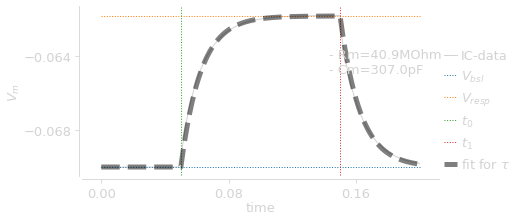

In [23]:
sim = GridSimulation(os.path.join('data', 'calib', 'passive-grid.npz'))
sim_results = {'Rm':np.zeros(sim.N), 'Cm':np.zeros(sim.N)}

# looping over simulations
for index in range(int(sim.N)):
    output = load_dict(os.path.join('data', 'calib', sim.params_filename(index)+'.npz'))
    Rm, Cm = perform_ICcharact(1e-3*output['t'],
                               1e-3*output['Vm_soma'],
                               t0=50e-3, t1=150e-3)
    sim_results['Rm'][index], sim_results['Cm'][index] = Rm, Cm

# perform minimization
to_minimize = (1+(sim_results['Rm']-expRm)**2/sim_results['Rm']**2)*\
    (1+(sim_results['Cm']-expCm)**2/sim_results['Cm']**2)
ibest = np.argmin(to_minimize)
# show output
output = load_dict(os.path.join('data', 'calib', sim.params_filename(ibest)+'.npz'))
fig, ax, Rm, Cm = perform_ICcharact(1e-3*output['t'], 1e-3*output['Vm_soma'],
                                    t0=50e-3, t1=150e-3, with_plot=True, ge=ge)

# save results as default passive props
from model import Model
sim.update_dict_from_GRID_and_index(ibest, Model) # update Model parameters
print(Model['gL'], Model['cm'])
np.savez(os.path.join('data','passive-props-cesium.npz'), **{'gL':Model['gL'], 'cm':Model['cm'], 'filename':os.path.join('data', 'calib', sim.params_filename(ibest)+'.npz')})

# Calibrating Zinc-NMDA properties on Extracellular stimulation data

## Extracellular stimulation data: 3Hz and 20hz 

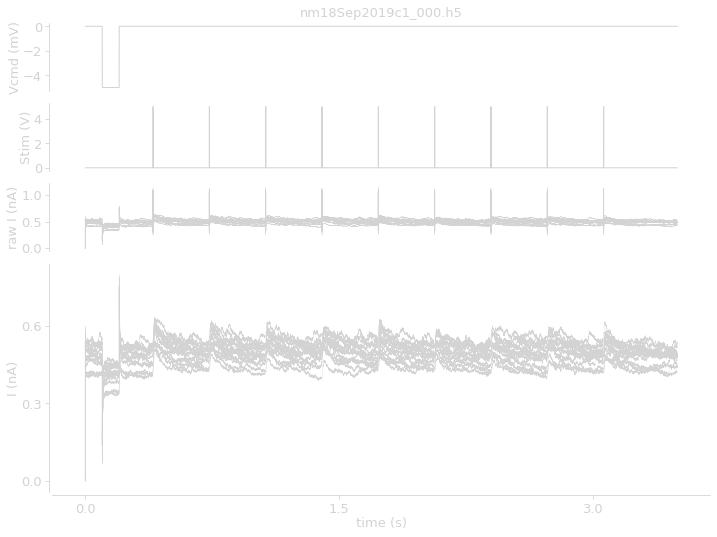

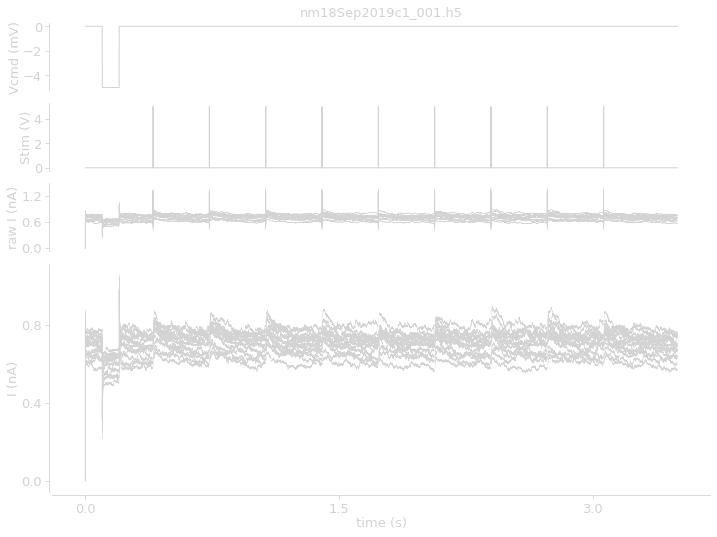

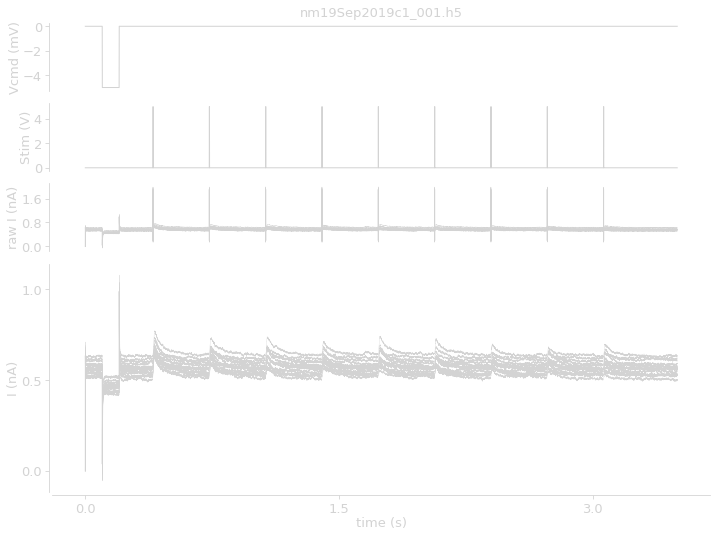

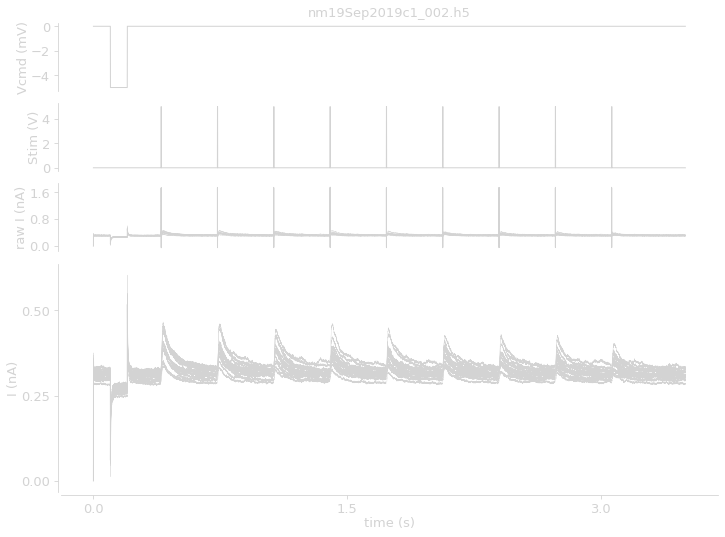

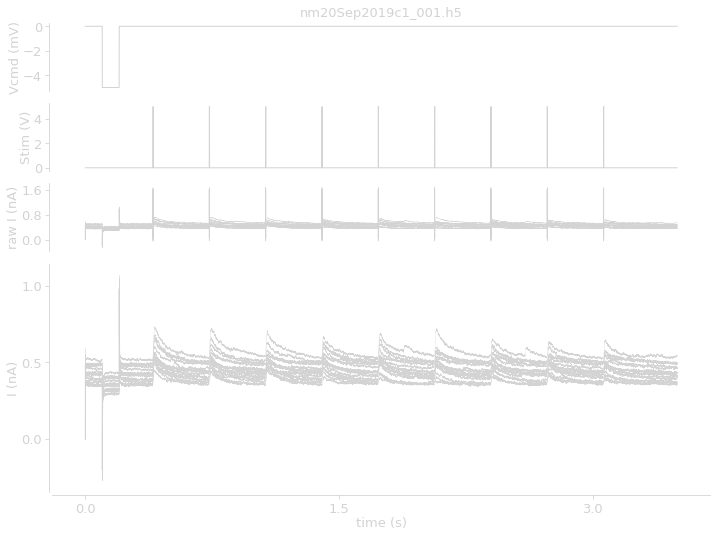

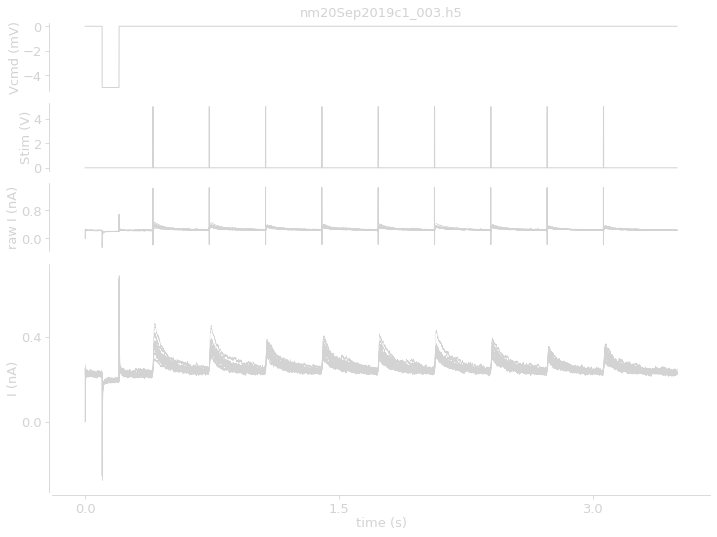

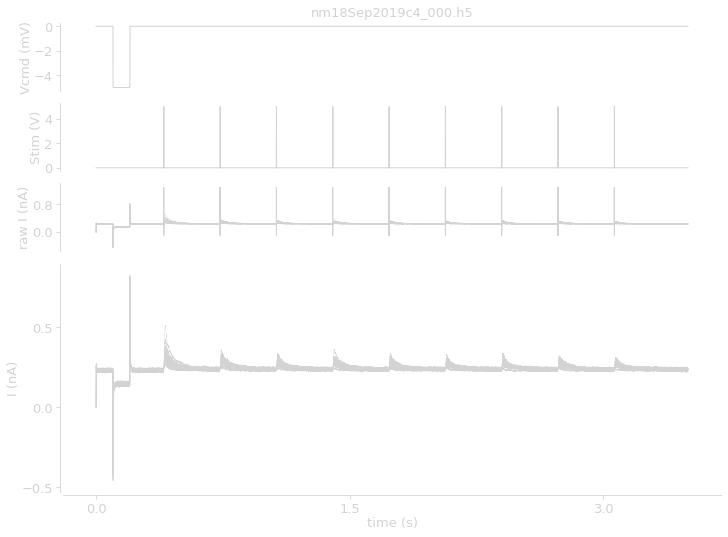

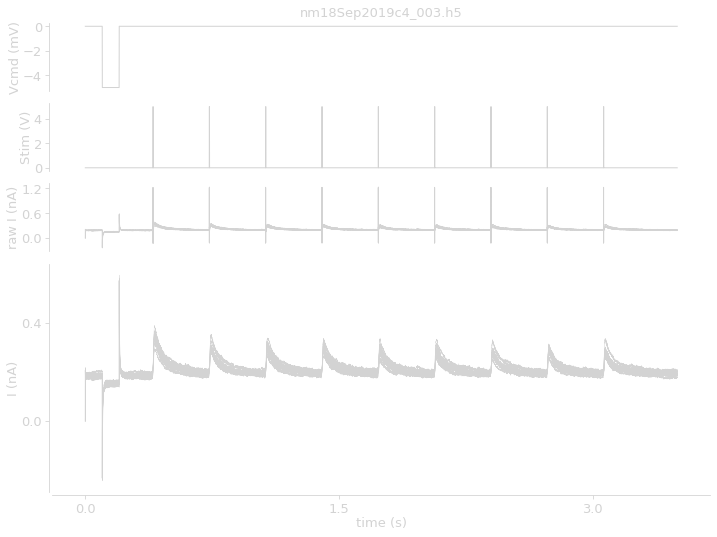

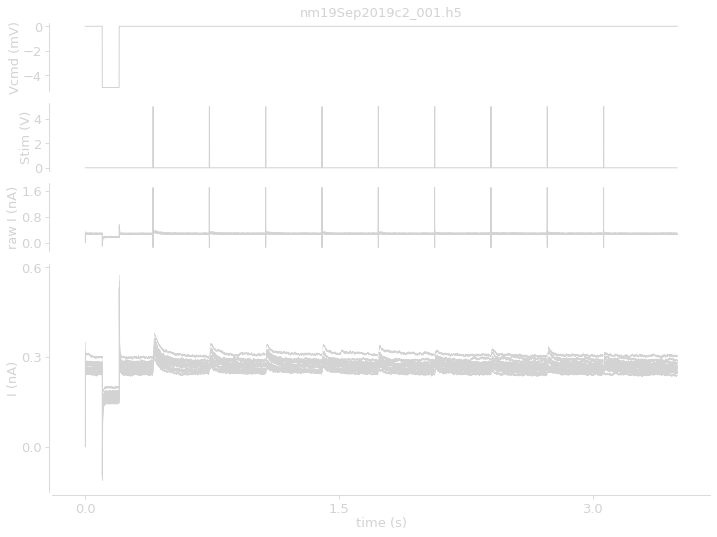

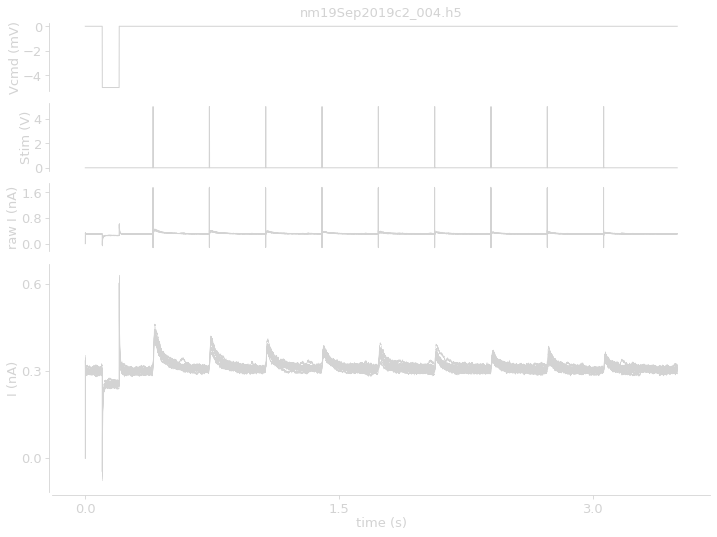

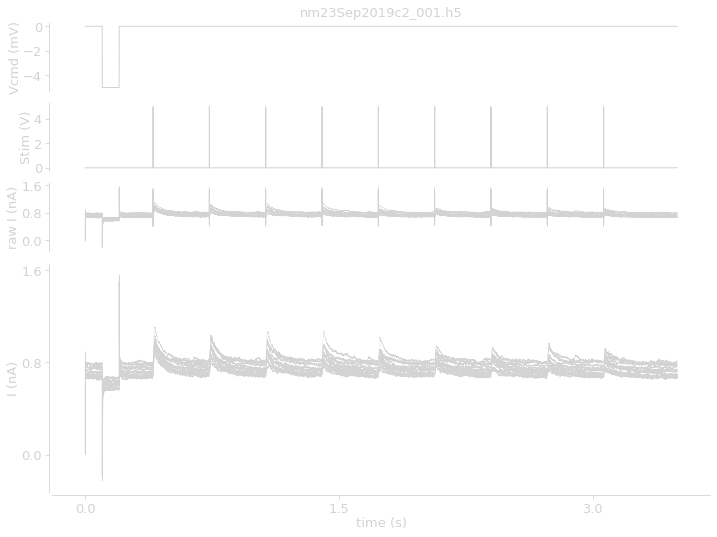

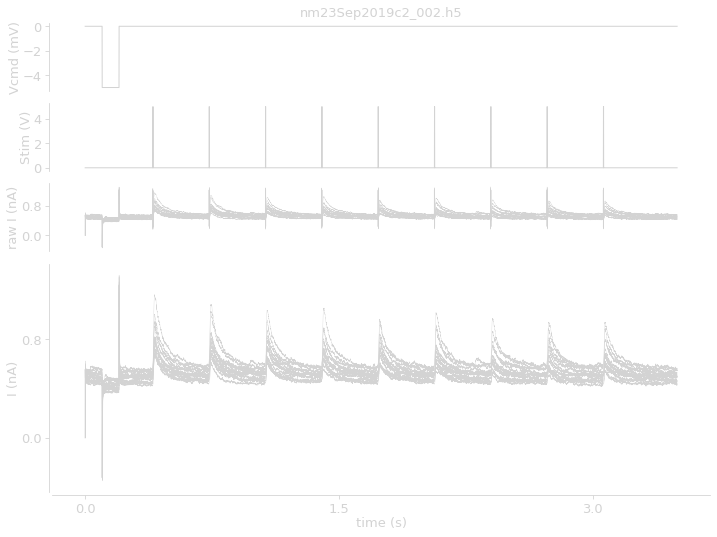

In [90]:
cond = '3Hz_protocol'
for i, cell in enumerate(DATASET[cond]):
    data_ctrl = LoadData(cond, iexp=i, condition='Control')
    plot_protocol(data_ctrl)
    data_test = LoadData(cond, iexp=i, condition='Tricine')
    plot_protocol(data_test)

In [44]:
def compute_norm_trace(data,
                       window_for_peak=20, # ms
                       pre_window = 150, # ms
                       t0=400,
                       with_all=False):

    tcond = (data['t']>t0-pre_window)
    baseline_cond = (data['t']>t0-pre_window) & (data['t']<t0)
    baseline = data['recordings']['Irecording_clean'].mean(axis=0)[baseline_cond].mean()

    trace = data['recordings']['Irecording_clean'].mean(axis=0)[tcond]-baseline
    stim = data['stimulations'][data['stim_key']][tcond]
    stim_events = np.argwhere((stim[:-1]<2) & (stim[1:]>=2)).flatten()
    peak_cond = (data['t'][tcond]>=t0) & (data['t'][tcond]<=t0+window_for_peak)

    norm_trace = trace/np.max(trace[peak_cond])

    if with_all:
        return data['t'][tcond], stim_events, norm_trace, np.max(trace[peak_cond])
    else:
        return norm_trace

    
def protocol_comparison(DATA,
                        labels=['Control', 'Tricine'],
                        colors=['k', ge.green],
                        window_for_peak=20, # ms
                        pre_window = 150, # ms
                        t0=400):
    fig, AX = ge.figure(axes=(1,3), figsize=(2,1.3), hspace=0.3)
    for data, c in zip(DATA, colors):
        AX[0].plot(1e-3*data['t'], data['recordings'][data['Irec_key']].mean(axis=0), color=c)
    ge.set_plot(AX[0], ['left'], ylabel='raw-I (nA)')

    for data, label, c in zip(DATA, labels, colors):
        tcond = (data['t']>t0-pre_window)
        baseline_cond = (data['t']>t0-pre_window) & (data['t']<t0)
        baseline = data['recordings']['Irecording_clean'].mean(axis=0)[baseline_cond].mean()
        trace = data['recordings']['Irecording_clean'].mean(axis=0)[tcond]-baseline
        
        peak_cond = (data['t'][tcond]>t0) & (data['t'][tcond]<t0+window_for_peak)
        norm_trace = compute_norm_trace(data, window_for_peak, pre_window, t0)
        
        AX[1].plot(1e-3*data['t'][tcond], trace, color=c, label=label)
        AX[2].plot(1e-3*data['t'][tcond], norm_trace, color=c, label=label)
        
    ge.set_plot(AX[1], ['left'], ylabel='I (nA)\n (-baseline&stim)')
    ge.set_plot(AX[2], xlabel='time (s)', ylabel='I (nA)\n (-baseline&stim)\n (+rescaled)')
    
    ge.legend(AX[1])
    return fig, AX


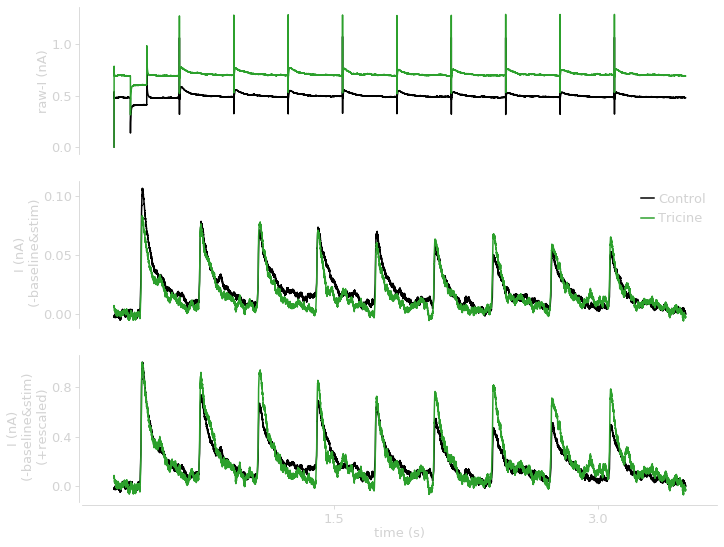

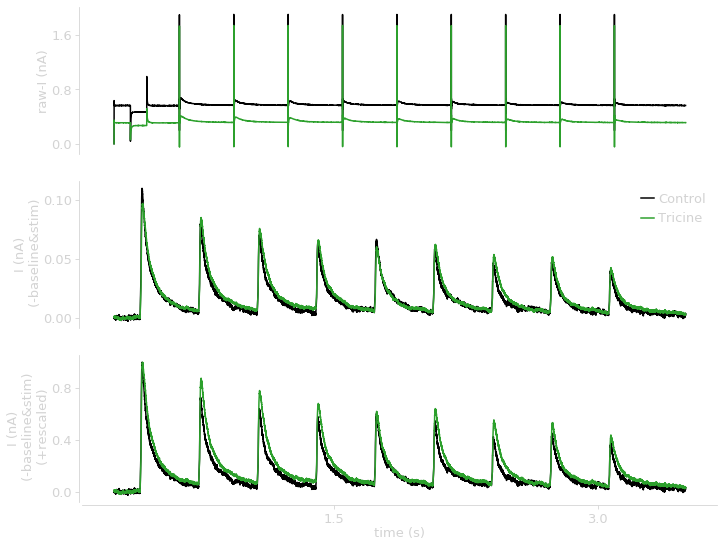

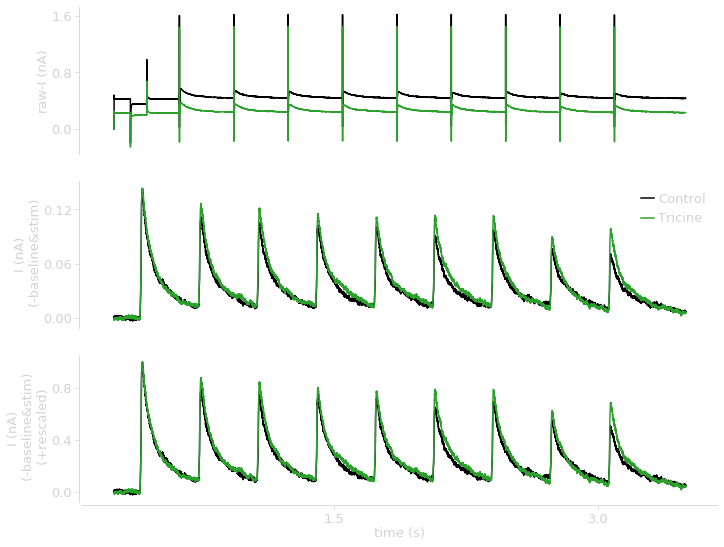

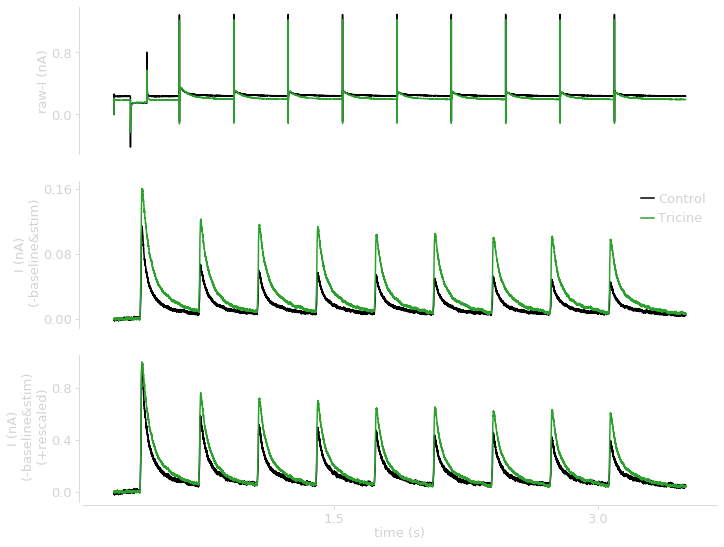

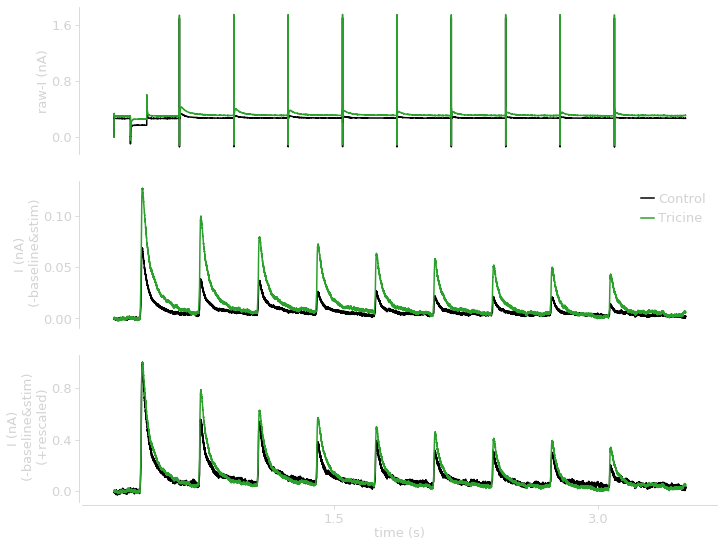

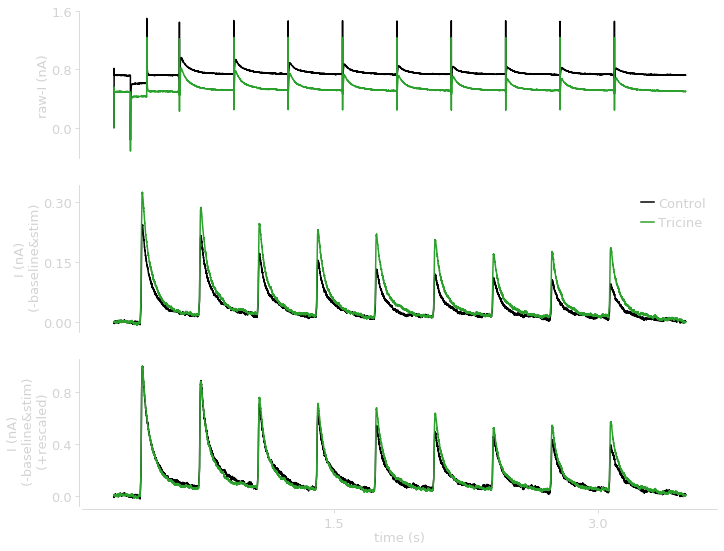

In [92]:
cond = '3Hz_protocol'
for i, cell in enumerate(DATASET[cond]):
    data_ctrl = LoadData(cond, iexp=i, condition='Control')
    data_test = LoadData(cond, iexp=i, condition='Tricine')
    protocol_comparison([data_ctrl, data_test])

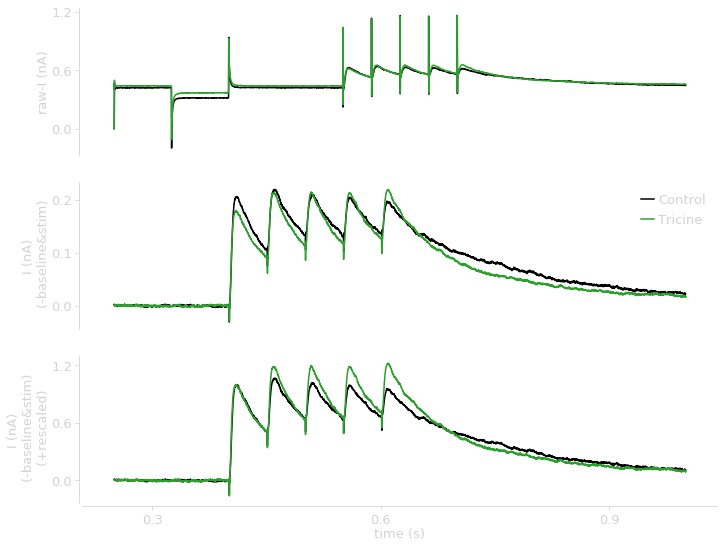

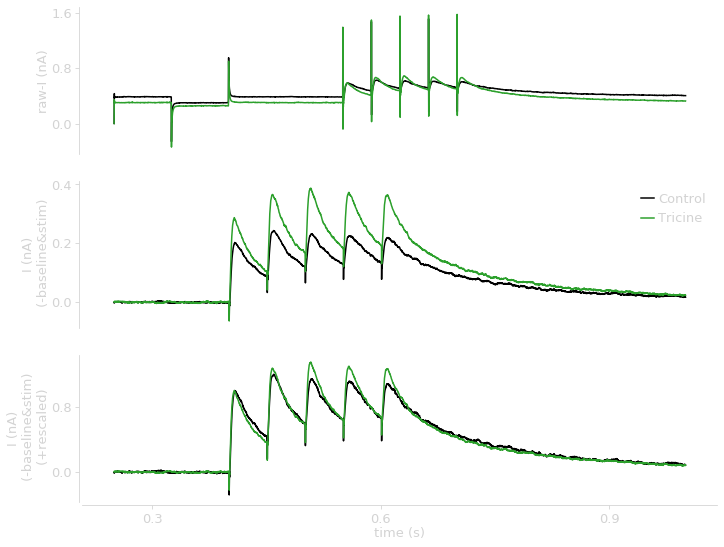

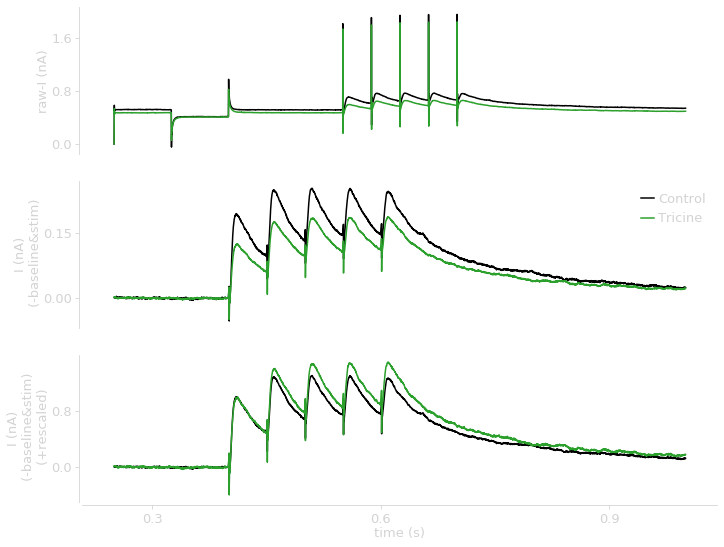

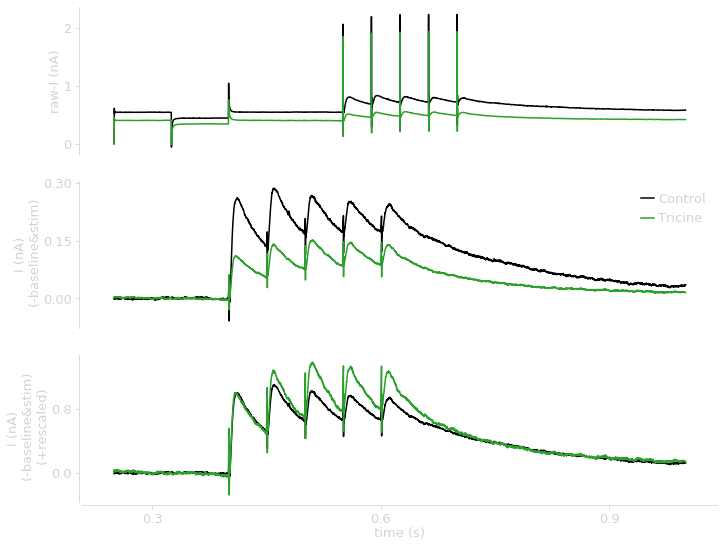

In [292]:
cond = '20Hz_protocol'
for i, cell in enumerate(DATASET[cond]):
    data_ctrl = LoadData(cond, iexp=i, condition='Control')
    data_test = LoadData(cond, iexp=i, condition='Tricine')
    protocol_comparison([data_ctrl, data_test])

In [46]:
FDATA = {}
for cond in ['3Hz_protocol', '20Hz_protocol']:
    norm_trace_ctrl, norm_trace_test = [], []
    scale_ctrl, scale_test = [], []
    for i, cell in enumerate(DATASET[cond]):
        data_ctrl = LoadData(cond, iexp=i, condition='Control')
        t, se, n_trace, scale = compute_norm_trace(data_ctrl,
                                            window_for_peak=20,
                                            pre_window = 150,
                                            t0=400, with_all=True)
        norm_trace_ctrl.append(n_trace)
        scale_ctrl.append(scale)
        data_test = LoadData(cond, iexp=i, condition='Tricine')
        t, se, n_trace, scale = compute_norm_trace(data_test,
                                            window_for_peak=20,
                                            pre_window = 150,
                                            t0=400, with_all=True)
        norm_trace_test.append(n_trace)
        scale_test.append(scale)
    FDATA[cond] = {'norm_trace_ctrl':np.array(norm_trace_ctrl),
                   'norm_trace_test':np.array(norm_trace_test),
                   't':t,
                   'se':se,
                   'scale_ctrl':np.array(scale_ctrl),
                   'scale_test':np.array(scale_test)}
    
np.savez('data/full_data_for_calibration.npz', **FDATA)


## Minimation procedure

In [5]:
# toy model data

def build_stimulation():
    
    dt, tstop = 0.1, 5000.
    t = np.arange(int(tstop/dt))*dt
    model = {'t':t}
    events = np.empty(0)
    for cond, t0, freq_pulses, n_pulses in zip(['20Hz_protocol', '3Hz_protocol'],
                                               [500,1700], [20., 3.], [5, 9]) :

        new_events = t0+np.arange(n_pulses)*1e3/freq_pulses
        events = np.concatenate([events, new_events])
        model['%s_tstart' % cond] = t0
    model['events'] = events
    return model

model = build_stimulation()



In [2]:
from datavyz import gedn as ge

In [50]:

calibration_constraints = {}
for cond, ax in zip(['20Hz_protocol', '3Hz_protocol'], AX):
    
    ## exp
    DT0 = FDATA[cond]['t'][FDATA[cond]['se'][0]]-FDATA[cond]['t'][0]
    DTfull = FDATA[cond]['t'][-1]-FDATA[cond]['t'][0]
    new_t = FDATA[cond]['t'][::10][:-1]-FDATA[cond]['t'][0]
    calibration_constraints['DT0_%s' % cond] = DT0
    calibration_constraints['DTfull_%s' % cond] = FDATA[cond]['t'][-1]-FDATA[cond]['t'][0]
    calibration_constraints['t_%s' % cond] = new_t

    # tricine cond
    te0 = FDATA[cond]['norm_trace_test'].mean(axis=0)*1e3*FDATA[cond]['scale_test'].mean()
    trace_exp = te0[::10][:-1] # subsampling at 1kHz
    calibration_constraints['Iexp_chelated_%s' % cond] = trace_exp
    
    # control cond
    te0 = FDATA[cond]['norm_trace_ctrl'].mean(axis=0)*1e3*FDATA[cond]['scale_ctrl'].mean()
    trace_exp = te0[::10][:-1] # subsampling at 1kHz
    calibration_constraints['Iexp_zinc_%s' % cond] = trace_exp
    
np.savez('data/exp_data_for_calibration.npz', **calibration_constraints)


## Perform calibration on Tricine case: chelated Zinc

In [53]:
import numpy as np
import itertools, os

In [149]:
N=8
GRID = {'tauDecayNMDA':np.linspace(65, 120, N),
        'Nsyn1':np.linspace(5, 50, N, dtype=int),
        'Nsyn2':np.linspace(5, 50, N, dtype=int),
        'Tnsyn':np.linspace(100, 2000, N)}

np.savez(os.path.join('data', 'calib', 'chelated-zinc-calib-grid.npz'), **GRID)

# Making a bash script to run a scan on the above grid grid
sim = GridSimulation(GRID) # os.path.join('data', 'calib', 'passive-grid.npz'))
bs = bash_script('calib-chelated-zinc')
bs.script = sim.build_script('python calibration-runs.py chelated-zinc-calib',
                             base_script=bs.script, simultaneous_runs=3*8)
bs.write(folder='./bash/')

### Find minimum

In [6]:
import os
import numpy as np
from analyz.IO.npz import load_dict
from analyz.workflow.batch_run import GridSimulation

calib_data = load_dict('data/exp_data_for_calibration.npz')

sim = GridSimulation(os.path.join('data', 'calib', 'chelated-zinc-calib-grid.npz'))

def compute_residual(index, condition='chelated'):

    try:
        sim_data = load_dict(os.path.join('data', 'calib', sim.params_filename(index)+'.npz'))
        Residual = 1.
        for cond in ['20Hz_protocol', '3Hz_protocol']:
            tcond = (sim_data['t']>(sim_data['%s_tstart' % cond]-calib_data['DT0_%s' % cond])) &\
                (sim_data['t']<sim_data['%s_tstart' % cond]-calib_data['DT0_%s' % cond]+\
                 calib_data['DTfull_%s' % cond])
            trace_model = -1e3*(sim_data['Ic'][tcond]-sim_data['Ic'][tcond][0]) # - sign
            trace_exp = calib_data['Iexp_%s_%s' % (condition, cond)]
            Residual *= 1+np.sum((trace_model-trace_exp)**2)/np.sum((trace_exp)**2)
    except FileNotFoundError:
        print(sim.params_filename(index)+'.npz', 'not found')
        Residual = 1e10
    return Residual


Residuals = np.ones(int(sim.N))*np.inf
for i in range(int(sim.N)):
    Residuals[i] = compute_residual(i)

ibest = np.argmin(Residuals)
print(Residuals[ibest])
from model import Model
best_chelated_config = {'filename':os.path.join('data', 'calib', sim.params_filename(ibest)+'.npz')}
sim.update_dict_from_GRID_and_index(ibest, best_chelated_config) # update Model parameters
np.savez('data/best_chelated_config.npz', **best_chelated_config)
print(best_chelated_config)

1.0545270238572773
{'filename': 'data/calib/tauDecayNMDA_88.571429--Nsyn1_24--Nsyn2_11--Tnsyn_2000.000000.npz', 'tauDecayNMDA': 88.57142857142857, 'Nsyn1': 24, 'Nsyn2': 11, 'Tnsyn': 2000.0}


### Calibration results: chelated-Zinc

## Perform calibration on control case: free-Zinc

### Run the different parameters

In [27]:
import itertools, os
import numpy as np
from analyz.workflow.batch_run import slurm_script, bash_script, GridSimulation

Ngrid=2
GRID = {'alphaZn': np.linspace(0.3, 0.7, Ngrid),
        'tauRiseZn':np.logspace(np.log10(1), np.log10(40), Ngrid),
        'tauDecayZn':np.logspace(np.log10(20), np.log10(500), Ngrid),
        'Deltax0':np.linspace(0.3, 0.7, Ngrid),
        'deltax':np.linspace(0.05, 0.3, Ngrid)}

np.savez(os.path.join('data', 'calib', 'free-zinc-calib-grid.npz'), **GRID)

# Making a bash script to run a scan on the above grid grid
sim = GridSimulation(GRID) # os.path.join('data', 'calib', 'passive-grid.npz'))
bs = bash_script('calib-free-zinc')
bs.script = sim.build_script('python calibration-runs.py free-zinc-calib',
                             base_script=bs.script, simultaneous_runs=3*8)
bs.write(folder='./bash/')

### Find minimum

In [15]:
from analyz.IO.npz import load_dict as npz_load
calib_data = npz_load('data/exp_data_for_calibration.npz')

sim = GridSimulation(os.path.join('data', 'calib', 'free-zinc-calib-grid.npz'))

def compute_residual(index):
    """
    here we don't keep the absolute 
    """

    try:
        mdata = load_dict(os.path.join('data', 'calib', sim.params_filename(index)+'.npz'))

        Residual = 1
        for cond in ['20Hz_protocol', '3Hz_protocol']:

            tcond = (mdata['t']>(mdata['%s_tstart' % cond]-calib_data['DT0_%s' % cond])) &\
                (mdata['t']<mdata['%s_tstart' % cond]-calib_data['DT0_%s' % cond]+\
                 calib_data['DTfull_%s' % cond])

            trace_model = -1e3*(mdata['Ic'][tcond]-mdata['Ic'][tcond][0])
            trace_exp = calib_data['Iexp_zinc_%s' % cond]
            new_t = calib_data['t_%s' % cond]

            # normalizing to peak
            first_peak_cond = (calib_data['t_%s' % cond]<calib_data['DT0_%s' % cond]+30)
            trace_model /= np.max(trace_model[first_peak_cond])
            trace_exp /= np.max(trace_exp[first_peak_cond])

            Residual *= 1+np.sum((trace_model-trace_exp)**2)/np.sum(trace_exp**2)

    except FileNotFoundError:
        print(os.path.join('data', 'calib', sim.params_filename(index)+'.npz'), 'not found')
        Residual = 1e10
    
    return Residual

Residuals = np.ones(int(sim.N))*np.inf
for i in range(int(sim.N)):
    Residuals[i] = compute_residual(i)

ibest = np.argmin(Residuals)
print(Residuals[ibest])
from model import Model
best_free_config = {'filename':os.path.join('data', 'calib', sim.params_filename(ibest)+'.npz')}
sim.update_dict_from_GRID_and_index(ibest, best_free_config) # update Model parameters
np.savez('data/best_free_config.npz', **best_free_config)    
print(best_free_config)

data/calib/alphaZn_0.500000--tauRiseZn_3.419952--tauDecayZn_34.199519--Deltax0_0.300000--deltax_0.300000.npz not found
data/calib/alphaZn_0.500000--tauRiseZn_3.419952--tauDecayZn_34.199519--Deltax0_0.366667--deltax_0.050000.npz not found
data/calib/alphaZn_0.500000--tauRiseZn_3.419952--tauDecayZn_34.199519--Deltax0_0.366667--deltax_0.091667.npz not found
data/calib/alphaZn_0.500000--tauRiseZn_3.419952--tauDecayZn_34.199519--Deltax0_0.366667--deltax_0.133333.npz not found
data/calib/alphaZn_0.500000--tauRiseZn_3.419952--tauDecayZn_34.199519--Deltax0_0.366667--deltax_0.175000.npz not found
data/calib/alphaZn_0.500000--tauRiseZn_3.419952--tauDecayZn_34.199519--Deltax0_0.366667--deltax_0.216667.npz not found
data/calib/alphaZn_0.500000--tauRiseZn_3.419952--tauDecayZn_34.199519--Deltax0_0.366667--deltax_0.258333.npz not found
data/calib/alphaZn_0.500000--tauRiseZn_3.419952--tauDecayZn_34.199519--Deltax0_0.366667--deltax_0.300000.npz not found
data/calib/alphaZn_0.500000--tauRiseZn_3.419952-

data/calib/alphaZn_0.500000--tauRiseZn_6.324555--tauDecayZn_500.000000--Deltax0_0.433333--deltax_0.133333.npz not found
data/calib/alphaZn_0.500000--tauRiseZn_6.324555--tauDecayZn_500.000000--Deltax0_0.433333--deltax_0.175000.npz not found
data/calib/alphaZn_0.500000--tauRiseZn_6.324555--tauDecayZn_500.000000--Deltax0_0.433333--deltax_0.216667.npz not found
data/calib/alphaZn_0.500000--tauRiseZn_6.324555--tauDecayZn_500.000000--Deltax0_0.433333--deltax_0.258333.npz not found
data/calib/alphaZn_0.500000--tauRiseZn_6.324555--tauDecayZn_500.000000--Deltax0_0.433333--deltax_0.300000.npz not found
data/calib/alphaZn_0.500000--tauRiseZn_6.324555--tauDecayZn_500.000000--Deltax0_0.500000--deltax_0.050000.npz not found
data/calib/alphaZn_0.500000--tauRiseZn_6.324555--tauDecayZn_500.000000--Deltax0_0.500000--deltax_0.091667.npz not found
data/calib/alphaZn_0.500000--tauRiseZn_6.324555--tauDecayZn_500.000000--Deltax0_0.500000--deltax_0.133333.npz not found
data/calib/alphaZn_0.500000--tauRiseZn_6

data/calib/alphaZn_0.500000--tauRiseZn_11.696071--tauDecayZn_170.997595--Deltax0_0.366667--deltax_0.300000.npz not found
data/calib/alphaZn_0.500000--tauRiseZn_11.696071--tauDecayZn_170.997595--Deltax0_0.433333--deltax_0.050000.npz not found
data/calib/alphaZn_0.500000--tauRiseZn_11.696071--tauDecayZn_170.997595--Deltax0_0.433333--deltax_0.091667.npz not found
data/calib/alphaZn_0.500000--tauRiseZn_11.696071--tauDecayZn_170.997595--Deltax0_0.433333--deltax_0.133333.npz not found
data/calib/alphaZn_0.500000--tauRiseZn_11.696071--tauDecayZn_170.997595--Deltax0_0.433333--deltax_0.175000.npz not found
data/calib/alphaZn_0.500000--tauRiseZn_11.696071--tauDecayZn_170.997595--Deltax0_0.433333--deltax_0.216667.npz not found
data/calib/alphaZn_0.500000--tauRiseZn_11.696071--tauDecayZn_170.997595--Deltax0_0.433333--deltax_0.258333.npz not found
data/calib/alphaZn_0.500000--tauRiseZn_11.696071--tauDecayZn_170.997595--Deltax0_0.433333--deltax_0.300000.npz not found
data/calib/alphaZn_0.500000--tau

data/calib/alphaZn_0.566667--tauRiseZn_1.000000--tauDecayZn_20.000000--Deltax0_0.433333--deltax_0.300000.npz not found
data/calib/alphaZn_0.566667--tauRiseZn_1.000000--tauDecayZn_20.000000--Deltax0_0.500000--deltax_0.050000.npz not found
data/calib/alphaZn_0.566667--tauRiseZn_1.000000--tauDecayZn_20.000000--Deltax0_0.500000--deltax_0.091667.npz not found
data/calib/alphaZn_0.566667--tauRiseZn_1.000000--tauDecayZn_20.000000--Deltax0_0.500000--deltax_0.133333.npz not found
data/calib/alphaZn_0.566667--tauRiseZn_1.000000--tauDecayZn_20.000000--Deltax0_0.500000--deltax_0.175000.npz not found
data/calib/alphaZn_0.566667--tauRiseZn_1.000000--tauDecayZn_20.000000--Deltax0_0.500000--deltax_0.216667.npz not found
data/calib/alphaZn_0.566667--tauRiseZn_1.000000--tauDecayZn_20.000000--Deltax0_0.500000--deltax_0.258333.npz not found
data/calib/alphaZn_0.566667--tauRiseZn_1.000000--tauDecayZn_20.000000--Deltax0_0.500000--deltax_0.300000.npz not found
data/calib/alphaZn_0.566667--tauRiseZn_1.000000-

data/calib/alphaZn_0.566667--tauRiseZn_1.000000--tauDecayZn_292.401774--Deltax0_0.433333--deltax_0.091667.npz not found
data/calib/alphaZn_0.566667--tauRiseZn_1.000000--tauDecayZn_292.401774--Deltax0_0.433333--deltax_0.133333.npz not found
data/calib/alphaZn_0.566667--tauRiseZn_1.000000--tauDecayZn_292.401774--Deltax0_0.433333--deltax_0.175000.npz not found
data/calib/alphaZn_0.566667--tauRiseZn_1.000000--tauDecayZn_292.401774--Deltax0_0.433333--deltax_0.216667.npz not found
data/calib/alphaZn_0.566667--tauRiseZn_1.000000--tauDecayZn_292.401774--Deltax0_0.433333--deltax_0.258333.npz not found
data/calib/alphaZn_0.566667--tauRiseZn_1.000000--tauDecayZn_292.401774--Deltax0_0.433333--deltax_0.300000.npz not found
data/calib/alphaZn_0.566667--tauRiseZn_1.000000--tauDecayZn_292.401774--Deltax0_0.500000--deltax_0.050000.npz not found
data/calib/alphaZn_0.566667--tauRiseZn_1.000000--tauDecayZn_292.401774--Deltax0_0.500000--deltax_0.091667.npz not found
data/calib/alphaZn_0.566667--tauRiseZn_1

# Minimization output

In [71]:
from datavyz import gedn as ge
from analyz.IO.npz import load_dict

In [22]:
output = load_dict(load_dict('data/passive-props-cesium.npz')['filename'])
fig, ax, Rm, Cm = perform_ICcharact(1e-3*output['t'], 1e-3*output['Vm_soma'],
                                    t0=50e-3, t1=150e-3, with_plot=True, ge=ge)


KeyError: 'filename'

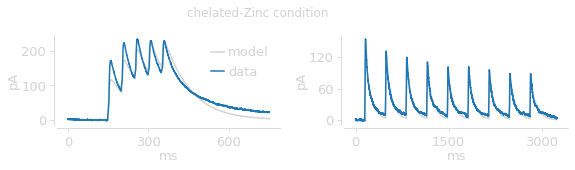

In [18]:
fig, AX = ge.figure(axes=(2,1), figsize=(1.2,0.8),
                    wspace=0.5, hspace=0)

calib_data = load_dict('data/exp_data_for_calibration.npz')
mdata = load_dict(load_dict('data/best_chelated_config.npz')['filename'])

for cond, ax in zip(['20Hz_protocol', '3Hz_protocol'], AX):
    ## data
    tcond = (mdata['t']>(mdata['%s_tstart' % cond]-calib_data['DT0_%s' % cond])) &\
        (mdata['t']<mdata['%s_tstart' % cond]-calib_data['DT0_%s' % cond]+\
         calib_data['DTfull_%s' % cond])
    
    trace_model = -1e3*(mdata['Ic'][tcond]-mdata['Ic'][tcond][0])
    trace_exp = calib_data['Iexp_chelated_%s' % cond]
    
    ax.plot(calib_data['t_%s' % cond], trace_model, color=ge.default_color, label='model')
    ax.plot(calib_data['t_%s' % cond], trace_exp, color=ge.blue, label='data')

    ge.set_plot(ax, ylabel='pA', xlabel='ms')
ge.legend(AX[0])
fig.suptitle('chelated-Zinc condition', color=ge.default_color);

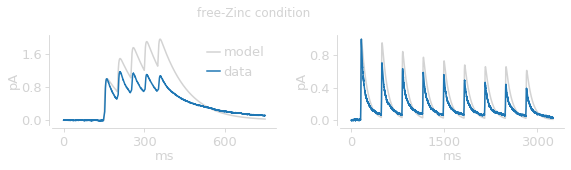

In [21]:
from analyz.IO.npz import load_dict
from datavyz import gedn as ge

fig, AX = ge.figure(axes=(2,1), figsize=(1.2,0.8),
                    wspace=0.5, hspace=0)

calib_data = load_dict('data/exp_data_for_calibration.npz')
mdata = load_dict(load_dict('data/best_free_zinc_config.npz')['filename'])

for cond, ax in zip(['20Hz_protocol', '3Hz_protocol'], AX):
    ## data
    tcond = (mdata['t']>(mdata['%s_tstart' % cond]-calib_data['DT0_%s' % cond])) &\
        (mdata['t']<mdata['%s_tstart' % cond]-calib_data['DT0_%s' % cond]+\
         calib_data['DTfull_%s' % cond])
    
    trace_model = -1e3*(mdata['Ic'][tcond]-mdata['Ic'][tcond][0])
    trace_exp = calib_data['Iexp_zinc_%s' % cond]

    # normalizing to peak
    first_peak_cond = (calib_data['t_%s' % cond]<calib_data['DT0_%s' % cond]+30)
    norm_model = 1./np.max(trace_model[first_peak_cond])
    norm_exp = 1./np.max(trace_exp[first_peak_cond])
    
    # ax.plot(calib_data['t_%s' % cond], trace_model, color=ge.default_color, label='model')
    ax.plot(calib_data['t_%s' % cond], norm_model*trace_model, color=ge.default_color, label='model')
    ax.plot(calib_data['t_%s' % cond], norm_exp*trace_exp, color=ge.blue, label='data')

    ge.set_plot(ax, ylabel='pA', xlabel='ms')
ge.legend(AX[0])

fig.suptitle('free-Zinc condition', color=ge.default_color);

NameError: name 't' is not defined

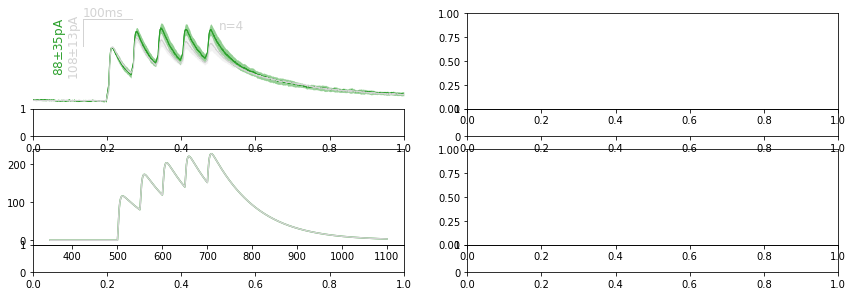

NameError: name 't' is not defined

In [13]:
from analyz.IO.npz import load_dict

MDATA = {'free':load_dict(load_dict('data/best_free_zinc_config.npz')['filename']),
         'chelated':load_dict(load_dict('data/best_chelated_config.npz')['filename'])}
FDATA = load_dict('data/full_data_for_calibration.npz')

fig, AX = ge.figure(axes_extents=[[[1,7],[1,7]],
                                  [[1,2],[1,2]],
                                  [[1,1],[1,1]],
                                  [[1,7],[1,7]],
                                  [[1,2],[1,2]]],
                    figsize=(1.55,0.12),
                    wspace=0.3, hspace=0, right=0.)

for ax in AX[2]:
    ax.axis('off')
    
for cond, ax, ax1, ax2, ax3, I0, t0, DI, T in zip(['20Hz_protocol', '3Hz_protocol'],
                                                  AX[0], AX[1], AX[3], AX[4], [1.5, 1.1],
                                        [100, 0], [0.5, 0.5], [100, 500]):

    ## exp
    ax.plot(FDATA[cond]['t'][0]+t0+np.zeros(2), [I0,I0-DI], lw=1, color=ge.default_color)
    ax.plot(FDATA[cond]['t'][0]+t0+np.arange(2)*T, [I0, I0], lw=1, color=ge.default_color)
    ge.annotate(ax, '%.0f$\pm$%.0fpA' % (1e3*FDATA[cond]['scale_ctrl'].mean()*DI,
                1e3*FDATA[cond]['scale_ctrl'].std()*DI),
                (FDATA[cond]['t'][0]+t0, I0-DI), xycoords='data', rotation=90,
                ha='right', va='center', size='small')
    ge.annotate(ax, '%.0f$\pm$%.0fpA\n' % (1e3*FDATA[cond]['scale_test'].mean()*DI,
                1e3*FDATA[cond]['scale_test'].std()*DI),
                (FDATA[cond]['t'][0]+t0, I0-DI), xycoords='data', rotation=90,
                ha='right', color=ge.green, va='center', size='small')
    ge.plot(FDATA[cond]['t'], FDATA[cond]['norm_trace_test'].mean(axis=0),
            sy=FDATA[cond]['norm_trace_test'].std(axis=0), ax=ax, color=ge.green)
    ge.plot(FDATA[cond]['t'], FDATA[cond]['norm_trace_test'].mean(axis=0),
            sy=FDATA[cond]['norm_trace_test'].std(axis=0), ax=ax, color=ge.green)
    ge.plot(FDATA[cond]['t'], FDATA[cond]['norm_trace_ctrl'].mean(axis=0),
            sy=FDATA[cond]['norm_trace_ctrl'].std(axis=0), ax=ax)
    ge.annotate(ax, 'n=%i' % len(FDATA[cond]['norm_trace_ctrl']), (.5,.8), size='small')
    ge.annotate(ax, '%ims' % T, (FDATA[cond]['t'][0]+t0, I0), xycoords='data', size='small')
    ge.set_plot(ax,[], xlim=[FDATA[cond]['t'][0], FDATA[cond]['t'][-1]])


    ## model
    DT0 = FDATA[cond]['t'][FDATA[cond]['se'][0]]-FDATA[cond]['t'][0]
    DTfull = FDATA[cond]['t'][-1]-FDATA[cond]['t'][0]

    YSCALE = 100
    tcond = (MDATA['free']['t']>(MDATA['free']['%s_tstart' % cond]-DT0)) &\
        (MDATA['free']['t']<(MDATA['free']['%s_tstart' % cond]-DT0+DTfull))
    for output, c in zip([MDATA['chelated'], MDATA['free']], [ge.green, ge.default_color]):
        trace = -(output['Ic'][tcond]-output['Ic'][tcond][0])
        tt = output['t'][tcond]
        ax2.plot(tt, 1e3*trace, color=c)
        
    ax2.plot(output['t'][tcond][0]-t[0]+t0+np.zeros(2), [.4*YSCALE, 1.4*YSCALE], lw=1, color=ge.default_color)
    ge.annotate(ax2, '%ipA' % YSCALE, (output['t'][tcond][0]-t[0]+t0, .4*YSCALE), xycoords='data', rotation=90, ha='right', va='bottom', size='small')
        
    ge.set_plot(ax2,[], xlim=[output['t'][tcond][0], output['t'][tcond][-1]])

    
    x, y = [output['t'][tcond][0]], [0]
    for e, n in zip(output['events'], output['Npicked']):
        x += [e,e,e]
        y += [0,1,0]
        ge.annotate(ax3, str(n), (e, 0.1), size='small', xycoords='data',
                    rotation=90, color=ge.purple)
    x += [output['t'][tcond][-1]]
    y += [0]
    x, y = np.array(x), np.array(y)
    tcond = (x>=output['t'][tcond][0]) & (x<=output['t'][tcond][-1])
    ax1.plot(x[tcond], y[tcond], 'k-', lw=1)
    ax3.plot(x[tcond], y[tcond], 'k-', lw=1)
    ge.set_plot(ax1,[], xlim=[x[tcond][0],x[tcond][-1]], ylim=[-.1,1.1])
    ge.set_plot(ax3,[], xlim=[x[tcond][0],x[tcond][-1]], ylim=[-.1,1.1])

ge.annotate(AX[0][0], 'Data', (.8,.5), italic=True, bold=True)
ge.annotate(AX[3][0], 'Model', (.8,.5), italic=True, bold=True)
ge.annotate(AX[1][0], 'electrical stim.', (1.,.1), ha='right', size='small')
ge.annotate(AX[4][0], 'synaptic act.', (1.,.1), ha='right', size='small', color=ge.purple)
#fig.savefig('figures/calibration.svg')    